<a href="https://colab.research.google.com/github/Juandavidmarint/data-analysis-logistica/blob/main/prediccion_entregas_logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modelo de predicción de tiempos de entrega usando Machine Learning

In [1]:
from google.colab import files
uploaded = files.upload()


Saving pedidos_logistica_grande.csv to pedidos_logistica_grande (1).csv


Revisión inicial de la información

In [2]:
import pandas as pd

# Cargar el archivo
df = pd.read_csv("pedidos_logistica_grande.csv")

# Vista previa de los datos
df.head()


,pedido_id,fecha_pedido,fecha_entrega,producto,origen,destino,distancia_km,medio_transporte,clima,tiempo_entrega_real
0,1,2023-04-04,2023-04-10,Pantalón,Lima,Bogotá,2034,Avión,Lluvioso,6
1,2,2023-08-10,2023-11-12,Camisa,Valparaíso,Buenos Aires,2815,Barco,Nublado,94
2,3,2023-01-10,2023-04-20,Pantalón,Lima,Medellín,2979,Barco,Nublado,100
3,4,2023-08-11,2023-10-15,Camisa,Buenos Aires,Santiago,1842,Barco,Tormenta,65
4,5,2023-05-07,2023-05-14,Zapatos,Bogotá,Medellín,268,Moto,Nublado,7


In [3]:
# Información general de columnas y tipos de datos
df.info()

# Estadísticas descriptivas numéricas
df.describe()

# Verificar valores nulos
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   pedido_id            10000 non-null  int64 
 1   fecha_pedido         10000 non-null  object
 2   fecha_entrega        10000 non-null  object
 3   producto             10000 non-null  object
 4   origen               10000 non-null  object
 5   destino              10000 non-null  object
 6   distancia_km         10000 non-null  int64 
 7   medio_transporte     10000 non-null  object
 8   clima                10000 non-null  object
 9   tiempo_entrega_real  10000 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 781.4+ KB


,0
pedido_id,0
fecha_pedido,0
fecha_entrega,0
producto,0
origen,0
destino,0
distancia_km,0
medio_transporte,0
clima,0
tiempo_entrega_real,0


In [5]:
print(df.columns)


Index(['pedido_id', 'fecha_pedido', 'fecha_entrega', 'producto', 'origen',
       'destino', 'distancia_km', 'medio_transporte', 'clima',
       'tiempo_entrega_real'],
      dtype='object')


<ipython-input-6-f5477f295582>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=promedio_entrega.values, y=promedio_entrega.index, palette="coolwarm")


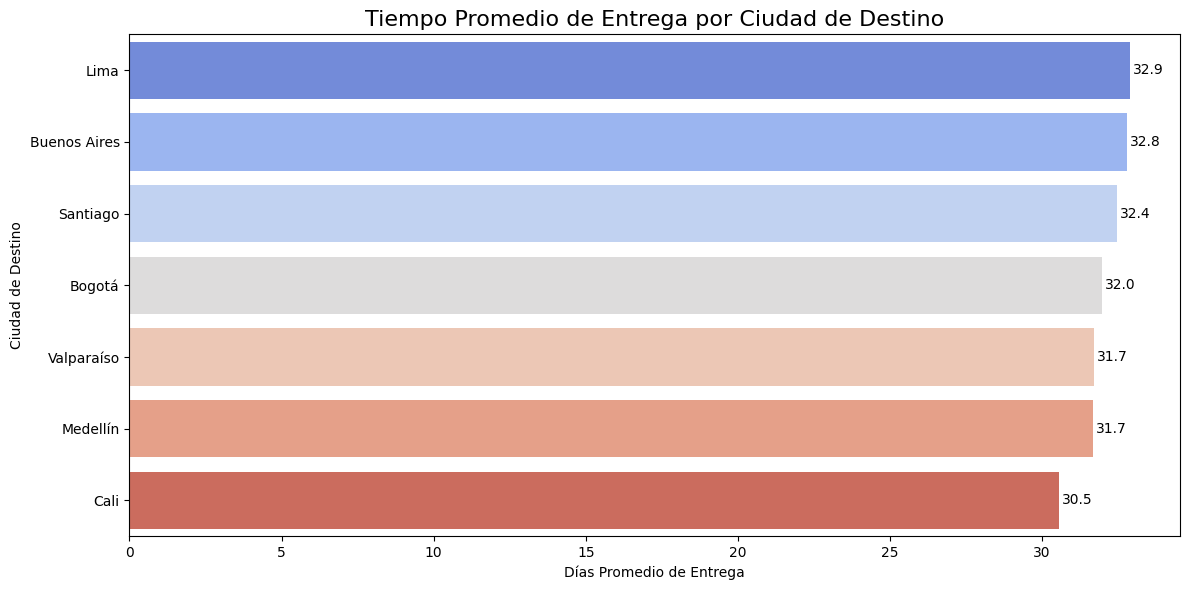

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular el promedio de tiempo de entrega por ciudad de destino
promedio_entrega = df.groupby("destino")["tiempo_entrega_real"].mean().sort_values(ascending=False)

# Configurar el estilo de la gráfica
plt.figure(figsize=(12, 6))
sns.barplot(x=promedio_entrega.values, y=promedio_entrega.index, palette="coolwarm")

# Añadir títulos y etiquetas
plt.title("Tiempo Promedio de Entrega por Ciudad de Destino", fontsize=16)
plt.xlabel("Días Promedio de Entrega")
plt.ylabel("Ciudad de Destino")

# Mostrar los valores en las barras
for index, value in enumerate(promedio_entrega.values):
    plt.text(value + 0.1, index, f"{value:.1f}", va='center')

plt.tight_layout()
plt.show()


A continuación se identifican posibles variables utiles para el modelo de predicción

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Copia del dataframe original
df_ml = df.copy()

# Extraer características de fechas
df_ml["fecha_pedido"] = pd.to_datetime(df_ml["fecha_pedido"])
df_ml["mes_pedido"] = df_ml["fecha_pedido"].dt.month
df_ml["dia_pedido"] = df_ml["fecha_pedido"].dt.day
df_ml["dia_semana"] = df_ml["fecha_pedido"].dt.weekday

# Seleccionar columnas predictoras y objetivo
X = df_ml[["distancia_km", "medio_transporte", "clima", "origen", "destino", "mes_pedido", "dia_pedido", "dia_semana"]]
y = df_ml["tiempo_entrega_real"]

# Columnas categóricas
categorical_cols = ["medio_transporte", "clima", "origen", "destino"]

# Codificador para columnas categóricas
preprocessor = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

# División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline con RandomForest
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Entrenar modelo
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Evaluación
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} días")
print(f"RMSE: {rmse:.2f} días")
print(f"R²: {r2:.2f}")


MAE: 0.92 días
RMSE: 1.15 días
R²: 1.00


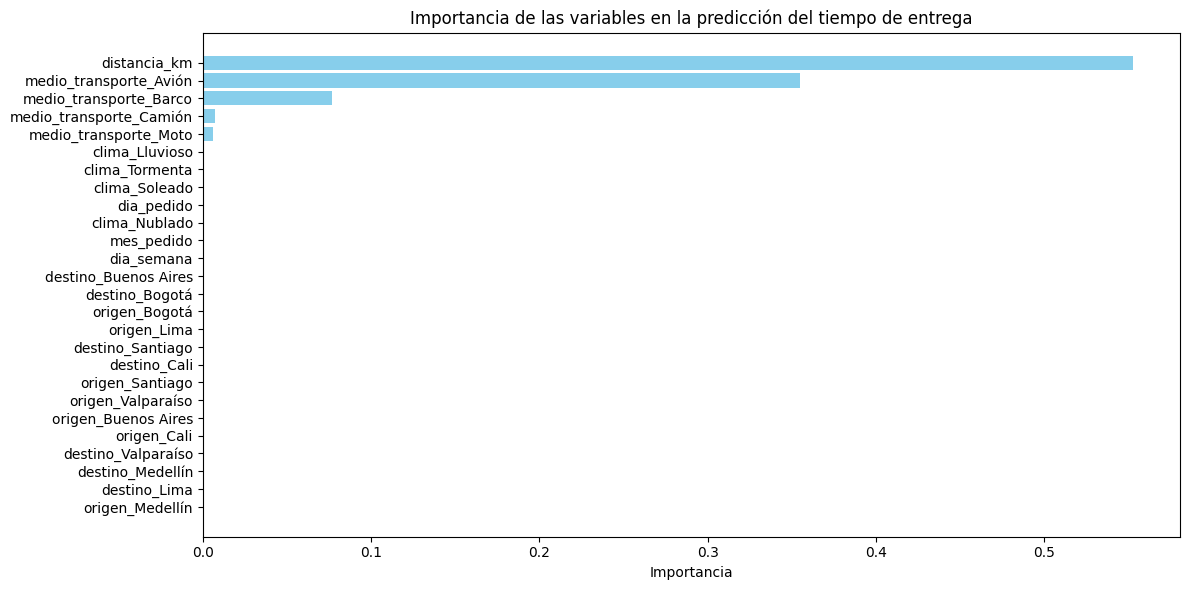

In [8]:
import matplotlib.pyplot as plt

# Extraer nombres de las columnas después del preprocesamiento
onehot_columns = model.named_steps["preprocessor"].transformers_[0][1].get_feature_names_out(categorical_cols)
feature_names = list(onehot_columns) + ["distancia_km", "mes_pedido", "dia_pedido", "dia_semana"]

# Obtener importancias del modelo
importances = model.named_steps["regressor"].feature_importances_

# Crear DataFrame de importancias
importancia_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Graficar
plt.figure(figsize=(12, 6))
plt.barh(importancia_df["feature"], importancia_df["importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.title("Importancia de las variables en la predicción del tiempo de entrega")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()


Una vez definida la importancia de las variables, evaluamos el desempeño de nuestro modelo utilizando una métrica de error, como el Error Cuadrático Medio (RMSE), para ver qué tan preciso es el modelo.

In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el RMSE (Raíz del Error Cuadrático Medio)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Mostrar el resultado
print(f"RMSE (Error Cuadrático Medio) del modelo: {rmse:.2f} días")


RMSE (Error Cuadrático Medio) del modelo: 1.15 días


Ahora se grafican las predicciones contra los valores reales, con la intención de evaluar nuevamente la validez del modelo

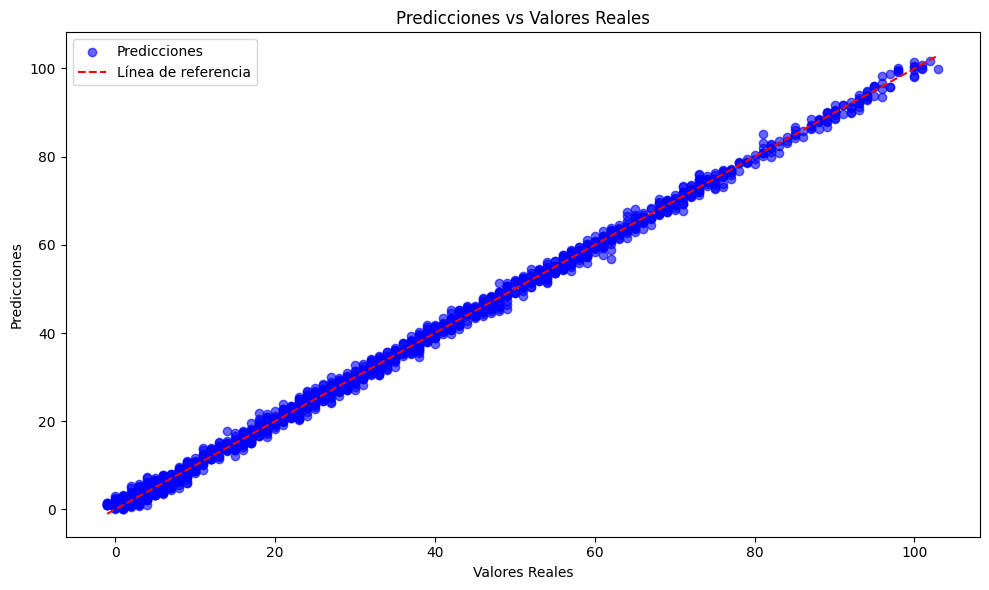

In [10]:
# Graficar las predicciones vs los valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="b", label="Predicciones")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label="Línea de referencia")
plt.title("Predicciones vs Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
import joblib

# Guardar el modelo entrenado con todo el pipeline
joblib.dump(model, "modelo_entregas_pipeline.pkl")


['modelo_entregas_pipeline.pkl']

In [19]:
# Cargar modelo entrenado
modelo_cargado = joblib.load("modelo_entregas_pipeline.pkl")

# Simular un nuevo pedido (puedes modificar estos valores)
nuevo_pedido = pd.DataFrame([{
    "distancia_km": 320.0,
    "medio_transporte": "Camión",
    "clima": "Lluvia",
    "origen": "Bogotá",
    "destino": "Medellín",
    "mes_pedido": 4,
    "dia_pedido": 23,
    "dia_semana": 2  # 0 = Lunes, 6 = Domingo
}])

# Predecir tiempo de entrega
prediccion = modelo_cargado.predict(nuevo_pedido)

print(f"🕒 Tiempo de entrega estimado: {prediccion[0]:.2f} días")


🕒 Tiempo de entrega estimado: 7.98 días


Creación de una interfaz mas amigable

In [20]:
!pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.1 MB/s eta 0:00:00


In [21]:
import pandas as pd
import joblib
import ipywidgets as widgets
from IPython.display import display


In [22]:
# Widgets para entrada de datos
distancia_widget = widgets.FloatSlider(value=100.0, min=0, max=2000, step=10, description='Distancia (km):')
medio_widget = widgets.Dropdown(options=["Camión", "Avión", "Barco", "Tren"], description='Transporte:')
clima_widget = widgets.Dropdown(options=["Soleado", "Lluvia", "Niebla", "Tormenta"], description='Clima:')
origen_widget = widgets.Dropdown(options=["Bogotá", "Medellín", "Santiago"], description='Origen:')
destino_widget = widgets.Dropdown(options=["Bogotá", "Medellín", "Santiago"], description='Destino:')
mes_widget = widgets.IntSlider(value=4, min=1, max=12, description='Mes:')
dia_widget = widgets.IntSlider(value=15, min=1, max=31, description='Día:')
dia_semana_widget = widgets.Dropdown(options=[(d, i) for i, d in enumerate(["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"])], description='Día semana:')


In [23]:
# Cargar modelo entrenado
modelo_cargado = joblib.load("modelo_entregas_pipeline.pkl")

# Función de predicción
def predecir_entrega(b):
    entrada = pd.DataFrame([{
        "distancia_km": distancia_widget.value,
        "medio_transporte": medio_widget.value,
        "clima": clima_widget.value,
        "origen": origen_widget.value,
        "destino": destino_widget.value,
        "mes_pedido": mes_widget.value,
        "dia_pedido": dia_widget.value,
        "dia_semana": dia_semana_widget.value
    }])

    pred = modelo_cargado.predict(entrada)[0]
    print(f"🚚 Tiempo estimado de entrega: {pred:.2f} días")

# Botón de predicción
boton = widgets.Button(description="Predecir")
boton.on_click(predecir_entrega)
